# Import bibliotek

In [39]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from matplotlib.colors import ListedColormap

In [40]:
data_rfm = pd.read_parquet('df.parquet')

### Features Used in training K Means - Log Transformed Recency, Frequency and Monetary values
data_norm = data_rfm[["log_R", "log_F", "log_M"]]

# Dobór parametrów
Aby dobrać parametry trzeba użyć metody łokieto

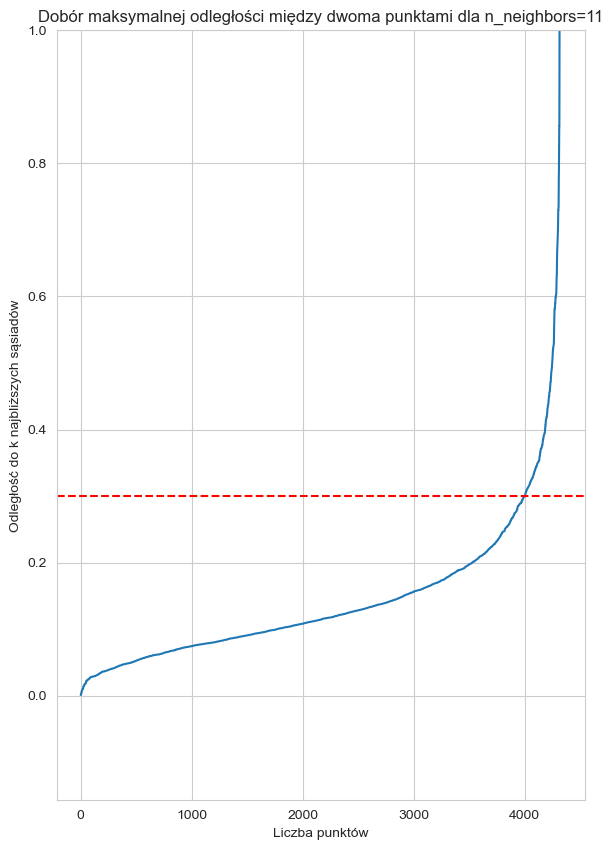

In [41]:
'''
for epsilon
https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

for min_samples
https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd
If your data has more than 2 dimensions, choose MinPts = 2*dim, where dim= the dimensions of your data set (Sander et al., 1998).

'''
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

n_neighbors = 11
nn = NearestNeighbors(n_neighbors=n_neighbors)
nn = nn.fit(data_norm)
distances, _ = nn.kneighbors(data_norm)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.subplot(1, 2, 1)
plt.plot(distances)
plt.title(f'Dobór maksymalnej odległości między dwoma punktami dla n_neighbors={n_neighbors}')
plt.xlabel('Liczba punktów')
plt.ylabel('Odległość do k najbliższych sąsiadów')
plt.ylim(top=1.)
plt.axhline(c='r', linestyle='--', y=0.3)
plt.rcParams["figure.figsize"] = (15, 10)
plt.show()

Wybieramy 3

# Algorytm

In [42]:
'''
eps = 0.5
min_samples = 9

model = DBSCAN(eps=eps, min_samples=min_samples)
model = model.fit(data_norm)
clusters = model.fit_predict(data_norm)

data_rfm['Cluster']= clusters
'''

"\neps = 0.5\nmin_samples = 9\n\nmodel = DBSCAN(eps=eps, min_samples=min_samples)\nmodel = model.fit(data_norm)\nclusters = model.fit_predict(data_norm)\n\ndata_rfm['Cluster']= clusters\n"

In [43]:
from sklearn.cluster import DBSCAN

eps = 0.3
min_samples = 11

model = DBSCAN(eps=eps, min_samples=min_samples)
clusters = model.fit_predict(data_norm)


data_rfm['Cluster']= clusters

# Analiza wyników

### Wykresy

In [44]:
sns.set_style("whitegrid")
data_rfm['Cluster'] = data_rfm['Cluster'].apply(str)

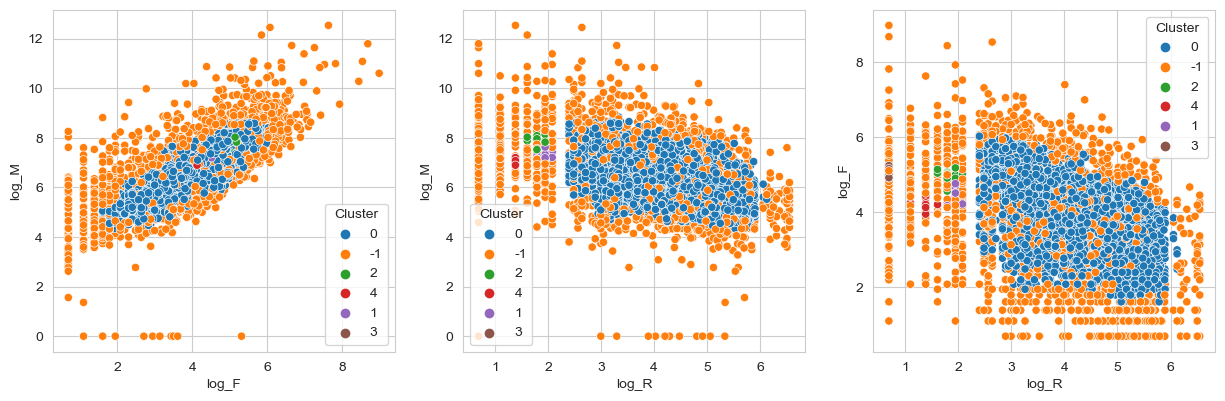

In [45]:
f, axes = plt.subplots(1, 3, subplot_kw=dict(box_aspect=1), figsize=(15, 15))
sns.scatterplot(data=data_rfm, x='log_F', y='log_M', hue='Cluster', ax=axes[0])
sns.scatterplot(data=data_rfm, x='log_R', y='log_M', hue='Cluster', ax=axes[1])
sns.scatterplot(data=data_rfm, x='log_R', y='log_F', hue='Cluster', ax=axes[2])

plt.show()

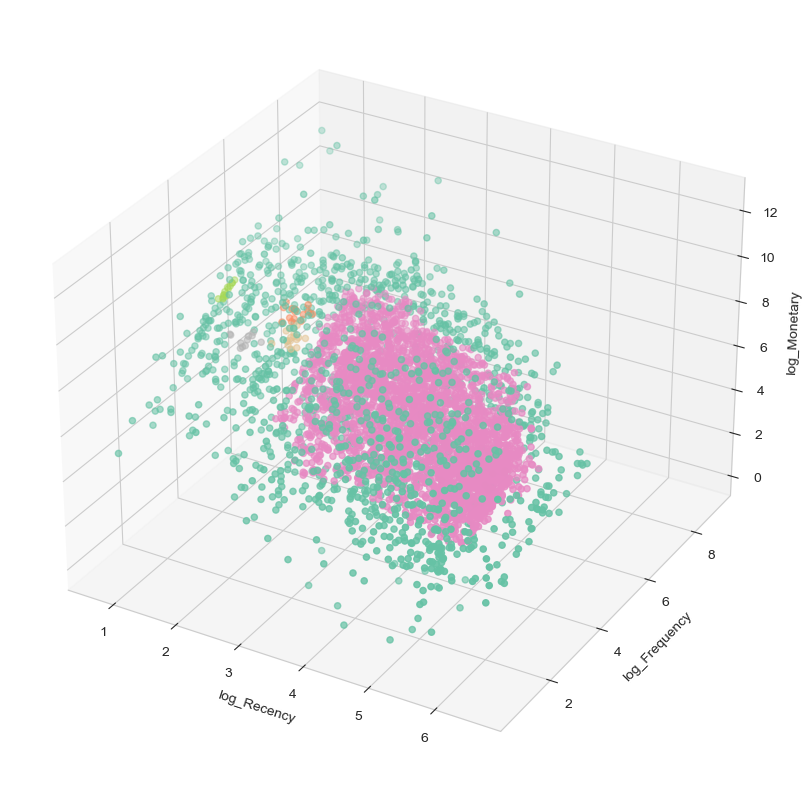

In [46]:
fig = plt.figure()
ax = plt.axes(projection='3d')
cmap = ListedColormap(sns.color_palette("Set2", 256).as_hex())
sns_plot = plt.axes (projection='3d')
sns_plot.scatter3D(data_rfm['log_R'], data_rfm['log_F'], data_rfm['log_M'],
                       c=data_rfm['Cluster'].apply(int), cmap=cmap)
sns_plot.set_xlabel ('log_Recency')
sns_plot.set_ylabel ('log_Frequency')
sns_plot.set_zlabel ('log_Monetary')
plt.show ()

### Analiza biznesowa

In [47]:
df_table = data_rfm.groupby('Cluster').agg({'Cluster': 'count','R_score': 'mean', 'F_score': 'mean', 'M_score':'mean', 'RFM_Score':'mean'})

In [48]:
df_result = data_rfm.groupby('Cluster').agg({'Cluster': 'count','R_score': 'mean', 'F_score': 'mean', 'M_score':'mean', 'RFM_Score':'mean'}).round(2)

df_result = df_result.rename_axis('Klaster').rename(columns={
    'Cluster': 'Liczba klientów',
    'R_score': 'Wartość R',
    'F_score': 'Wartość F',
    'M_score': 'Wartość M',
    'RFM_Score': 'Wartość RFM'
})

df_result

,Liczba klientów,Wartość R,Wartość F,Wartość M,Wartość RFM
Klaster,,,,,
-1,1314,1.81,1.47,1.64,4.92
0,2961,1.37,1.50,1.44,4.31
1,15,3.00,2.40,2.27,7.67
2,15,3.00,2.93,3.00,8.93
3,13,3.00,3.00,3.00,9.00
4,11,3.00,2.00,2.00,7.00


In [49]:
with open("csv_table.tex", 'w') as f:
    f.write(df_result.to_latex(index=True))

C:\Users\marce\AppData\Local\Temp\ipykernel_3380\191917624.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(df_result.to_latex(index=True))


### Analiza klastrów

In [50]:
from sklearn.metrics import silhouette_score,calinski_harabasz_score, davies_bouldin_score
from validclust import dunn
from sklearn.metrics import pairwise_distances

print(f'Wskaznik sylwetki: {silhouette_score(data_norm, data_rfm["Cluster"]).round(2)}')
print(f'Indeks CH: {calinski_harabasz_score(data_norm, data_rfm["Cluster"]).round(2)}')
print(f'Indeks DB: {davies_bouldin_score(data_norm, data_rfm["Cluster"]).round(2)}')
print(f'Indeks Dunn: {dunn(pairwise_distances(data_norm, metric="cityblock"), data_rfm["Cluster"]).round(5)}')

Wskaznik sylwetki: -0.03
Indeks CH: 41.65
Indeks DB: 2.8
Indeks Dunn: 0.00407


In [51]:
def assign_label_Recency(value):
    print(value)
    if 0 < value <= 1:
        return 'Utracony'
    elif 1 < value <= 2:
        return 'Odchodzący'
    elif 2 < value <= 3:
        return 'Aktywny'


def assign_label_Frequency_or_Monetary(value):
    if 0 < value <= 1:
        return 'Niska'
    elif 1 < value <= 2:
        return 'Średnia'
    elif 2 < value <= 3:
        return 'Wysoka'

def assign_label_Frequency_and_Monetary(value):
    if 0 < value <= 1:
        return 'Niska'
    elif 1 < value <= 2:
        return 'Średnia'
    elif 2 < value <= 3:
        return 'Wysoka'


In [52]:
df = df_table.copy()

df['Aktywność klienta'] = df['R_score'].apply(assign_label_Recency)
df['Częstotliwość zakupów'] = df['F_score'].apply(assign_label_Frequency_and_Monetary)
df['Wartość monetarna'] = df['M_score'].apply(assign_label_Frequency_and_Monetary)
df['Kategoria klientów R, F i M'] = df.apply(lambda row: f"{row['Aktywność klienta']}, {row['Częstotliwość zakupów']} częstotliwość, {row['Wartość monetarna']} wartość monetarna", axis=1)

1.8074581430745815
1.3657548125633232
3.0
3.0
3.0
3.0


In [53]:
def assign_label_Recency(value):
    print(value)
    if 0 < value <= 1:
        return 'Utracony'
    elif 1 < value <= 2:
        return 'Odchodzący'
    elif 2 < value <= 3:
        return 'Aktywny'


def assign_label_Frequency_or_Monetary(value):
    if 0 < value <= 1:
        return 'Niska'
    elif 1 < value <= 2:
        return 'Średnia'
    elif 2 < value <= 3:
        return 'Wysoka'

def assign_label_Frequency_and_Monetary(value):
    if 0 < value <= 1:
        return 'Niska'
    elif 1 < value <= 2:
        return 'Średnia'
    elif 2 < value <= 3:
        return 'Wysoka'

df = df_table.copy()

df['Aktywność klienta'] = df['R_score'].apply(assign_label_Recency)
df['Częstotliwość zakupów'] = df['F_score'].apply(assign_label_Frequency_and_Monetary)
df['Wartość monetarna'] = df['M_score'].apply(assign_label_Frequency_and_Monetary)
df['Kategoria klientów R, F i M'] = df.apply(lambda row: f"{row['Aktywność klienta']}, {row['Częstotliwość zakupów']} częstotliwość, {row['Wartość monetarna']} wartość monetarna", axis=1)
# Definiowanie funkcji przypisującej etykiety na podstawie wartości z kolumny 2 i Avg_FM
def assign_label_R_vs_FM(row):
    print(row)
    r_value = row['R_score']
    fm_value = (row['F_score'] + row['M_score']) / 2

    if 2 < r_value <= 3:
        if 2 < fm_value <= 3:
            fm_label = 'Czempioni'
        elif 1 < fm_value <= 2:
            fm_label = 'Obiecujący'
        elif 0 < fm_value <= 1:
            fm_label = 'Nowi klienci'

    elif 1 < r_value <= 2:
        if 2 < fm_value <= 3:
            fm_label = 'Lojalni klienci'
        elif 1 < fm_value <= 2:
            fm_label = 'Wymagają uwagi'
        elif 0 < fm_value <= 1:
            fm_label = 'Powinno się skontaktować'

    elif 0 < r_value <= 1:
        if 2 < fm_value <= 3:
            fm_label = 'Nie powinno się stracić'
        elif 1 < fm_value <= 2:
            fm_label = 'Odchodzący'
        elif 0 < fm_value <= 1:
            fm_label = 'Utraceni'

    return fm_label

df['Kategoria klientów R vs FM'] = df.apply(lambda row : assign_label_R_vs_FM(row), axis=1)

df = df.drop(columns=['RFM_Score', 'R_score', 'F_score', 'M_score'])
print(df)

1.8074581430745815
1.3657548125633232
3.0
3.0
3.0
3.0
Cluster                                                                     1314
R_score                                                                 1.807458
F_score                                                                 1.474125
M_score                                                                 1.639269
RFM_Score                                                               4.920852
Aktywność klienta                                                     Odchodzący
Częstotliwość zakupów                                                    Średnia
Wartość monetarna                                                        Średnia
Kategoria klientów R, F i M    Odchodzący, Średnia częstotliwość, Średnia war...
Name: -1, dtype: object
Cluster                                                                     2961
R_score                                                                 1.365755
F_score                        

In [54]:
with open("analiza_biznesowa.tex", 'w') as f:
    f.write(df.to_latex(index=True))

C:\Users\marce\AppData\Local\Temp\ipykernel_3380\1076251209.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(df.to_latex(index=True))


### Analiza algorytmu

In [55]:
import timeit

n = 10
stmt = '''
model = DBSCAN(eps=eps, min_samples=min_samples)
clusters = model.fit_predict(data_norm)
'''
result = timeit.timeit(stmt=stmt, globals=globals(), number=n)

print(f"Średni czas wykonania wynosi  {round(result / n, 3)} sekund")

Średni czas wykonania wynosi  0.049 sekund


In [56]:
import pandas as pd
from scipy.spatial.distance import euclidean
import sys

def intra_cluster_distance(cluster_points):
    distances = []
    for i in range(len(cluster_points)):
        for j in range(i+1, len(cluster_points)):
            distances.append(euclidean(cluster_points[i], cluster_points[j]))
    return max(distances) if distances else 0

def inter_cluster_distance(c1_points, c2_points):
    distances = []
    for point1 in c1_points:
        for point2 in c2_points:
            distances.append(euclidean(point1, point2))
    return min(distances) if distances else sys.maxsize

def dunn_index(data_norm, data_clusters):
    clusters = data_clusters.unique()
    clustered_points = {cluster: data_norm[data_clusters == cluster].values.tolist() for cluster in clusters}
    max_intra_cluster_dist = max([intra_cluster_distance(cluster_points) for cluster_points in clustered_points.values()])

    min_inter_cluster_dist = sys.maxsize
    for i, cluster1 in enumerate(clusters[:-1]):
        for cluster2 in clusters[i+1:]:
            dist = inter_cluster_distance(clustered_points[cluster1], clustered_points[cluster2])
            min_inter_cluster_dist = min(min_inter_cluster_dist, dist)

    return min_inter_cluster_dist / max_intra_cluster_dist

# Read data_norm from CSV or create a pandas DataFrame with three columns for coordinates
# data_norm = pd.read_csv('data_norm.csv')
# data_rfm = pd.read_csv('data_rfm.csv')

# Example: Creating a pandas DataFrame for demonstration purposes


# Calculate Dunn Index
result = dunn_index(data_norm, data_rfm['Cluster'])

print(f'Dunn Index: {result}')

Dunn Index: 0.005155842892391599
